In [13]:
from qdrant_client import QdrantClient, models
import torch
import os
import re
from PIL import Image as PIL_Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Image, display
import numpy as np
from typing import List, Dict, Union
import torch.nn as nn

In [2]:
client = QdrantClient(url="http://localhost:6333")

In [6]:
from qdrant_client.models import Distance, VectorParams
collection_name="Fusion"
collection_list = [c.name for c in client.get_collections().collections]
if collection_name not in collection_list:
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=512, distance=Distance.COSINE),
    )

In [7]:
def find_image_path_by_id(pokemon_id, folder_path='../images'):
    # List all files in the folder
    all_files = os.listdir(folder_path)
    
    # Filter files that start with the pokemon_id (e.g., '0001')
    matching_files = [file for file in all_files if file.startswith(pokemon_id)]
    
    # If a match is found, return the full file path(s)
    file_paths = [os.path.join(folder_path, file) for file in matching_files]
    
    return file_paths[0]

In [8]:
import json
json_path = './pokemon_data.json'
with open(json_path, 'r', encoding='utf-8') as file:
    pokemon_data = json.load(file)

In [9]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [10]:
import torch

def hierarchical_clip_encoding(text, max_tokens=77):
    """
    Performs hierarchical encoding of the input text using the CLIP model.
    
    Args:
        text (str): The input text to be encoded.
        max_tokens (int): The maximum number of tokens CLIP can handle.
        
    Returns:
        torch.Tensor: The aggregated CLIP embedding for the input text.
    """
    # Split the text into smaller chunks
    chunks = [text[i:i+max_tokens] for i in range(0, len(text), max_tokens)]
    
    # Encode each chunk using CLIP
    chunk_embeddings = []
    for chunk in chunks:
        input_ids = processor(chunk, return_tensors="pt").input_ids
        chunk_embedding = model.get_text_features(input_ids)
        chunk_embeddings.append(chunk_embedding)
    
    # Aggregate the chunk embeddings
    aggregated_embedding = torch.stack(chunk_embeddings, dim=0).mean(dim=0)
    
    return aggregated_embedding[0]

In [19]:
for poke_id, poke_info in pokemon_data.items():
    # Generate embedding for the Pokémon's description
    description_embedding = hierarchical_clip_encoding(poke_info["description"])

    image = PIL_Image.open(find_image_path_by_id(poke_id))
    image_input = processor(images=image, return_tensors="pt", padding=True)
    image_embedding = model.get_image_features(**image_input).squeeze().detach().cpu()

    combined_embedding = torch.cat([description_embedding, image_embedding], dim=-1)

    # Project the combined embedding to 512 dimensions
    projection_layer = nn.Linear(1024, 512)
    combined_embedding = projection_layer(combined_embedding)
    
    # Prepare metadata for filtering
    metadata = {
        "id": poke_id,
        "description": poke_info["description"],
        "name": poke_info["name"],
        "type": poke_info["type"],
        "species": poke_info["species"],
        "effectiveness": poke_info["effectiveness"],
        "height": poke_info["height_m"],
        "weight": poke_info["weight_kg"],
        "evolution": poke_info["evolution"],
        "path": find_image_path_by_id(poke_id)
    }
    
    # Upsert to Qdrant
    client.upsert(
        collection_name="Fusion",
        points=[
            {
                "id": int(poke_id),
                "vector": combined_embedding,
                "payload": metadata,
            }
        ]
    )

In [20]:
def search_pokemon(query: str, limit: int = 5) -> List[Dict[str, Union[str, float]]]:
    """
    Search Pokémon data based on a query.
    """
    text_query_embedding = hierarchical_clip_encoding(query)
    search_results = client.search(
        collection_name="Fusion",
        query_vector=text_query_embedding.tolist(),
        limit=limit
    )
    return [
        {
            "pokemon_id": result.id,
            "pokemon_name": result.payload["name"],
            "score": result.score,
            "text": result.payload["description"],
            "image_path": result.payload["path"]
        }
        for result in search_results
    ]

In [26]:
def display_comparison_with_query(query, fusion_results):
    """
    Display the query and a single column table for the fusion results.

    Args:
        query (str): The input query to display.
        fusion_results (list): Results from the fusion search.
    """
    from IPython.display import display, HTML
    import io
    import base64
    from PIL import Image

    def generate_cell(result):
        """Generate an HTML cell for a result."""
        import numbers

        try:
            # Load and encode image as base64
            image_path = result["image_path"]
            image = Image.open(image_path)
            buffer = io.BytesIO()
            image.save(buffer, format="PNG")
            img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")

            # Select score to display
            score = result.get("score", "N/A")
            score_text = f"Text Score: {score:.4f}" if isinstance(score, numbers.Number) else f"Text Score: {score}"

            # Return the HTML structure
            return f"""
            <div style="text-align: center; padding: 5px; border: 1px solid #ddd;">
                <img src="data:image/png;base64,{img_str}" alt="Image" style="max-width: 100px; height: auto; border-radius: 5px;">
                <h4>{result['pokemon_name']}</h4>
                <p>ID: {result['pokemon_id']}</p>
                <p>{score_text}</p>
            </div>
            """
        except Exception as e:
            # Handle errors for this specific result
            print(f"Error generating cell for result: {result}")
            print(e)
            return "<div>Error loading result</div>"

    # Display the query text
    query_html = f"<h3 style='text-align: center;'>Query: {query}</h3>"
    display(HTML(query_html))

    # Create HTML table
    html_content = "<table style='width: 100%; border-collapse: collapse;'>"
    html_content += """
        <tbody>
    """

    # Loop to generate rows (5 rows in this case)
    for i in range(5):
        html_content += "<tr>"
        html_content += "<td>"
        if i < len(fusion_results):
            html_content += generate_cell(fusion_results[i])
        html_content += "</td>"
        html_content += "</tr>"

    html_content += "</tbody></table>"

    # Display HTML table
    display(HTML(html_content))

Gloom ID: 44 Text Score: 0.1156
Charmander ID: 4 Text Score: 0.0947
Electrode ID: 101 Text Score: 0.0859
Machamp ID: 68 Text Score: 0.0846
Raticate ID: 20 Text Score: 0.0801

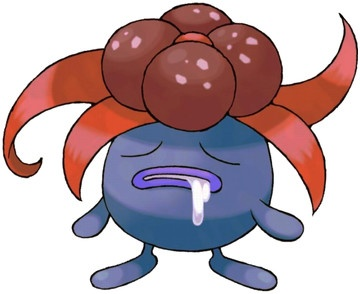
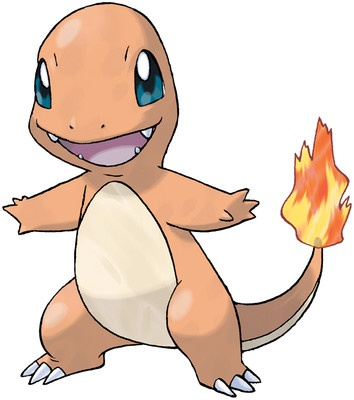
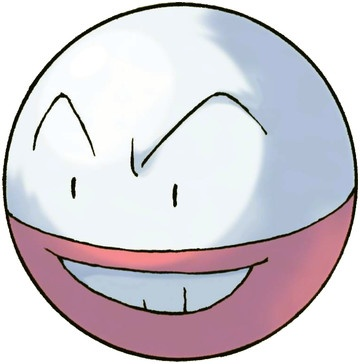
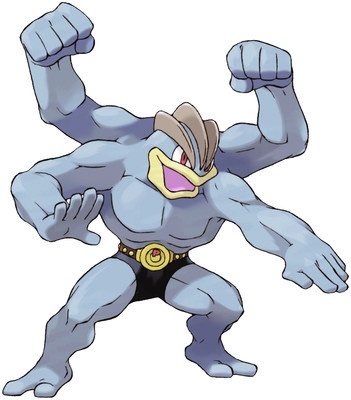
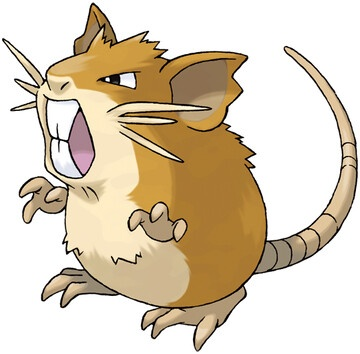

In [28]:
user_query = "a rat pokemon"
fusion_mode_result = search_pokemon(user_query)
display_comparison_with_query(user_query, fusion_mode_result)